In [16]:
from DataLoader import H5DataLoader
import numpy as np
import matplotlib.pyplot as plt
from pydub import AudioSegment
import os
import sys

In [14]:
DATASET_PATH = "../Samrecordings.h5"
AUDIO_SAMPLE_RATE  =  48000 #Hz
ADC_SAMPLE_RATE    =  8000  #Hz

In [ ]:
loader = H5DataLoader(DATASET_PATH)
datasets = loader.list_datasets()
print("Available datasets:", datasets)
EuropeData = loader.load_dataset("Europe")
print("Europe Audio :", len(EuropeData["audio_data"]))
print("Europe ADC channels:", EuropeData["adc_data"].keys())
print("Europe ADC ch 1:", EuropeData["adc_data"][1].shape)
print("Europe ADC ch 3 :", EuropeData["adc_data"][3].shape)

Available datasets: ['Child', 'Europe', 'Exactly', 'Joyce', 'Justice', 'NOISE', 'NOISE2', 'NOISE3', 'Question', 'Thought', 'Through', 'Weapons', 'XRay', 'XRay2']
Europe Aduio : 3652352
Europe ADC channels: dict_keys([1, 3])
Europe ADC ch 1: (304768,)
Europe ADC ch 3 : (304768,)


In [22]:
N_audio_samples = len(EuropeData["audio_data"])
N_adc_samples = len(EuropeData["adc_data"][1]) + len(EuropeData["adc_data"][3])
print("Europe Audio samples:", N_audio_samples)
print("Europe ADC samples:", N_adc_samples)
ratio = N_audio_samples / N_adc_samples
print("Audio to ADC ratio:", ratio)
expected_ratio = AUDIO_SAMPLE_RATE / ADC_SAMPLE_RATE
print("Expected ratio:", expected_ratio)

Europe Audio samples: 3652352
Europe ADC samples: 609536
Audio to ADC ratio: 5.992020159596808
Expected ratio: 6.0


Max Display duration: 76
Max non silence duration
in seconds: 1.30175
in samples: 62484.0
Min non silence duration
in seconds: 0.22329166666666667
in samples: 10718.0
Average non silence duration
in seconds: 0.6391513605442176
in samples: 30679.26530612245
Standard deviation non silence duration
in seconds: 0.30722678943799103
in samples: 14746.88589302357


/home/nicolas/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


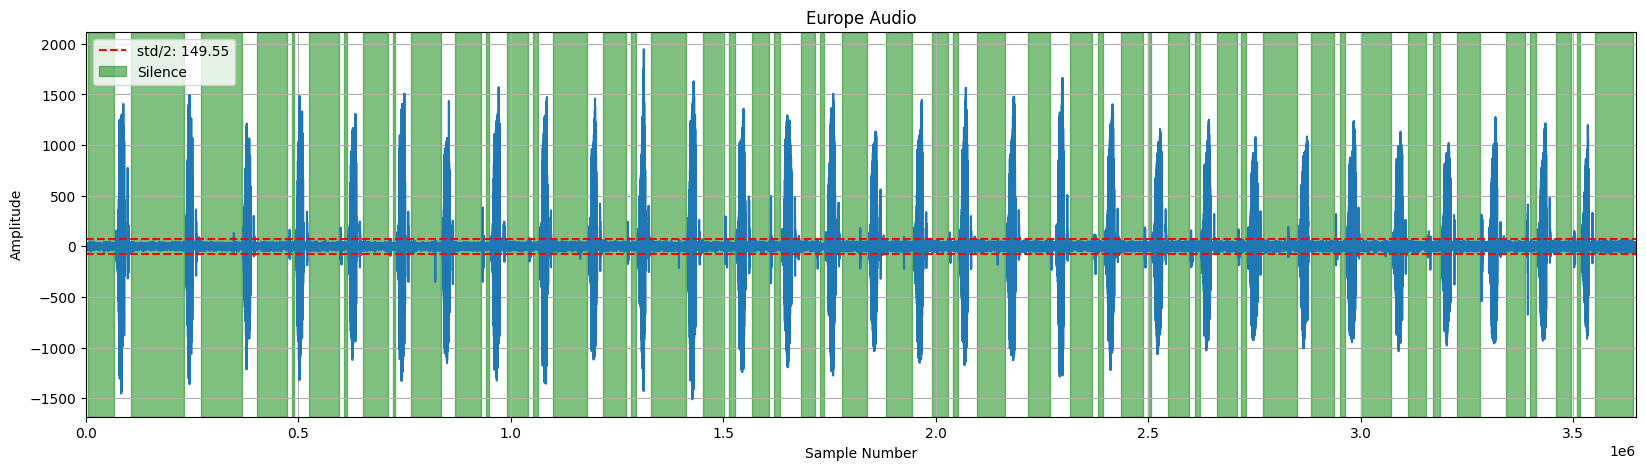

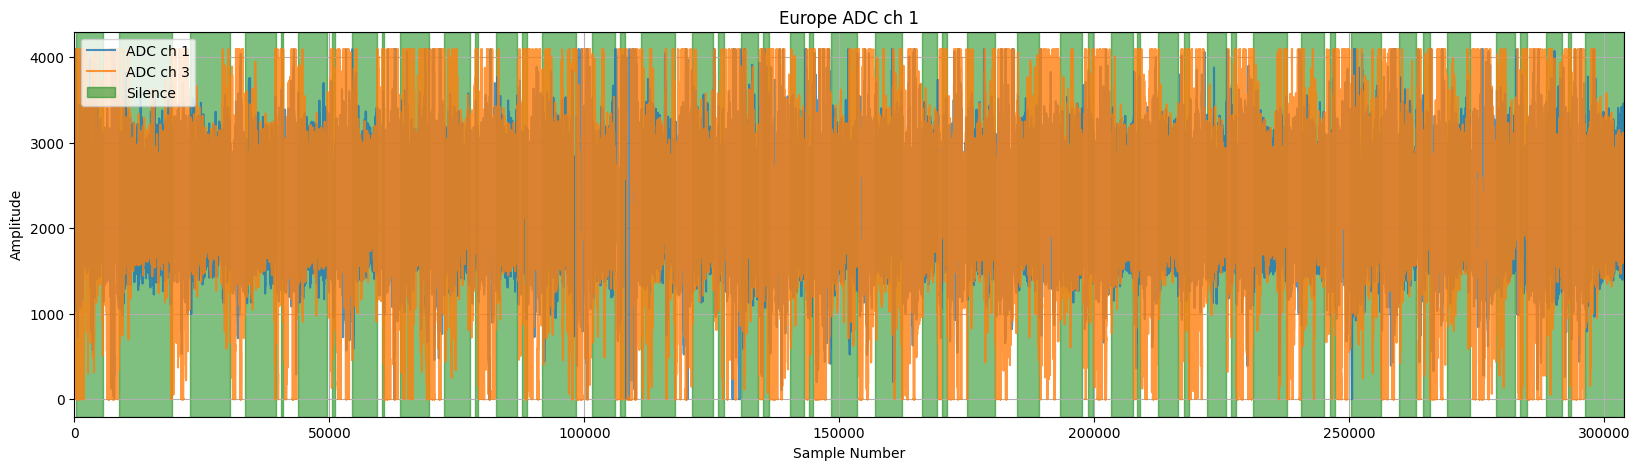

In [66]:
# graph the first 10 seconds of the audio
max_duration = 90  # seconds
if N_audio_samples / AUDIO_SAMPLE_RATE < max_duration:
    max_duration = N_audio_samples // AUDIO_SAMPLE_RATE
if N_adc_samples / ADC_SAMPLE_RATE < max_duration:
    max_duration = N_adc_samples // ADC_SAMPLE_RATE
print("Max Display duration:", max_duration)
# find long silences in the audio (where abs is less than std/2 and has to be continuous for at least min_silence_duration seconds)
std_audio = np.std(EuropeData["audio_data"][:max_duration * AUDIO_SAMPLE_RATE])
min_silence_duration = 0.3  # seconds
silences = []
start = None
for i in range(len(EuropeData["audio_data"][:max_duration * AUDIO_SAMPLE_RATE])):
    if abs(EuropeData["audio_data"][i]) < std_audio / 2:
        if start is None:
            start = i
    else:
        if start is not None and (i - start) >= min_silence_duration * AUDIO_SAMPLE_RATE:
            silences.append((start, i))
        start = None

# If the silence goes till the end of the segment
if start is not None and (len(EuropeData["audio_data"][:max_duration * AUDIO_SAMPLE_RATE]) - start) >= min_silence_duration * AUDIO_SAMPLE_RATE:
    silences.append((start, len(EuropeData["audio_data"][:max_duration * AUDIO_SAMPLE_RATE])))

# If the silence starts at the beginning of the segment
if silences and silences[0][0] != 0:
    silences.insert(0, (0, silences[0][0]))

# Unify silence blocks if they are less than x samples apart
x = 1000  # samples
unified_silences = []
prev_start, prev_end = silences[0]
for start, end in silences[1:]:
    if start - prev_end < x:
        prev_end = end
    else:
        unified_silences.append((prev_start, prev_end))
        prev_start, prev_end = start, end
unified_silences.append((prev_start, prev_end))
silences = unified_silences

margin = 0.1 # seconds
for i, (start, end) in enumerate(silences):
    start = max(0, start + margin * AUDIO_SAMPLE_RATE)
    end = min(len(EuropeData["audio_data"][:max_duration * AUDIO_SAMPLE_RATE]), end - margin * AUDIO_SAMPLE_RATE)
    silences[i] = (start, end)

silence_in_ADC = []
for (start, end) in silences:
    start_adc = int(start / ratio/2)
    end_adc = int(end / ratio/2)
    silence_in_ADC.append((start_adc, end_adc))

# average non silence duration 
average_non_silence_duration = 0
std_non_silence_duration = 0
max_non_silence_duration = 0
min_non_silence_duration = float('inf')
for i in range(len(silences) - 1):
    average_non_silence_duration += (silences[i + 1][0] - silences[i][1])
    max_non_silence_duration = max(max_non_silence_duration, silences[i + 1][0] - silences[i][1])
    min_non_silence_duration = min(min_non_silence_duration, silences[i + 1][0] - silences[i][1])
average_non_silence_duration /= len(silences) - 1
for i in range(len(silences) - 1):
    std_non_silence_duration += (silences[i + 1][0] - silences[i][1] - average_non_silence_duration) ** 2
std_non_silence_duration = (std_non_silence_duration / (len(silences) - 1)) ** 0.5
print("Max non silence duration")
print("in seconds:", max_non_silence_duration / AUDIO_SAMPLE_RATE)
print("in samples:", max_non_silence_duration)
print("Min non silence duration")
print("in seconds:", min_non_silence_duration / AUDIO_SAMPLE_RATE)
print("in samples:", min_non_silence_duration)
print("Average non silence duration")
print("in seconds:", average_non_silence_duration / AUDIO_SAMPLE_RATE)
print("in samples:", average_non_silence_duration)
print("Standard deviation non silence duration")
print("in seconds:", std_non_silence_duration / AUDIO_SAMPLE_RATE)
print("in samples:", std_non_silence_duration)


## Plotting

plt.figure(figsize=(20, 5))
plt.plot(EuropeData["audio_data"][:max_duration * AUDIO_SAMPLE_RATE])
plt.axhline(y=std_audio/2, color='r', linestyle='--', label=f"std/2: {std_audio:.2f}")
plt.axhline(y=-std_audio/2, color='r', linestyle='--')
# Plot the silences
once = True
for (start, end) in silences:
    if once:
        plt.axvspan(start, end, color='green', alpha=0.5, label="Silence")
        once = False
    else:
        plt.axvspan(start, end, color='green', alpha=0.5)
# for (start, end) in silences:
#     plt.axvspan(start, end, color='green', alpha=0.5, label="Silence")
plt.legend()
plt.title("Europe Audio")
plt.xlabel("Sample Number")
plt.ylabel("Amplitude")
plt.xlim(0, max_duration * AUDIO_SAMPLE_RATE)
plt.grid()

plt.figure(figsize=(20, 5))
plt.plot(EuropeData["adc_data"][1][:max_duration * ADC_SAMPLE_RATE//2], alpha=0.8, label="ADC ch 1")
plt.plot(EuropeData["adc_data"][3][:max_duration * ADC_SAMPLE_RATE//2], alpha=0.8, label="ADC ch 3")
once = True
for (start, end) in silence_in_ADC:
    if once:
        plt.axvspan(start, end, color='green', alpha=0.5, label="Silence")
        once = False
    else:
        plt.axvspan(start, end, color='green', alpha=0.5)
# for (start, end) in silence_in_ADC:
#     plt.axvspan(start, end, color='green', alpha=0.5, label="Silence")
plt.legend()
plt.title("Europe ADC ch 1")
plt.xlabel("Sample Number")
plt.ylabel("Amplitude")
plt.xlim(0, max_duration * ADC_SAMPLE_RATE//2)
plt.grid()
plt.show()